In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="businessmodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
businessFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [7]:
businessFOSID = businessFOSID.filter(businessFOSID["Domain"]=="Business").collect()

In [8]:
len(businessFOSID)

60

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(businessFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+---------+--------+
|   FOS_ID|  Domain|
+---------+--------+
|112698675|Business|
|162853370|Business|
+---------+--------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered.count()

586060

In [16]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [17]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [18]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [19]:
sample1 = papers_filtered1

In [20]:
sample1.count()

586060

In [21]:
from sklearn import model_selection
from sklearn.model_selection import KFold 

In [22]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             1|
|             0|
|            12|
|             1|
+--------------+
only showing top 4 rows



In [23]:
sample1_pd = sample1.toPandas()

In [24]:
import numpy as np

In [25]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [26]:
from sklearn import metrics

In [27]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 2.0294201958843803)
('Mean Squared Error of EstimatedCount:', 2967.592437634372)
('Root Mean Squared of with EstimatedCount:', 54.47561323780001)


In [28]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [29]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [30]:
from sklearn.model_selection import KFold

In [31]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 3.1727048160166853)
('Mean Squared Error:', 679.2961694831043)
('Root Mean Squared Error:', 26.063310792819557)
('Mean Absolute Error:', 1.364707869400863)
('Mean Squared Error:', 366.8886244365906)
('Root Mean Squared Error:', 19.154336961549742)
('Mean Absolute Error:', 0.49000569393396515)
('Mean Squared Error:', 57.502296763525166)
('Root Mean Squared Error:', 7.583026886641321)
('Mean Absolute Error:', 0.48712999064220913)
('Mean Squared Error:', 19.631699990738557)
('Root Mean Squared Error:', 4.43076742683912)
('Mean Absolute Error:', 1.6259701078171493)
('Mean Squared Error:', 998.0998369725073)
('Root Mean Squared Error:', 31.592718100418445)


In [34]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 17.764832033653637)


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
featureslist=sample1_pd.columns

In [37]:
importances = regressor.feature_importances_

In [38]:
import pandas as pd

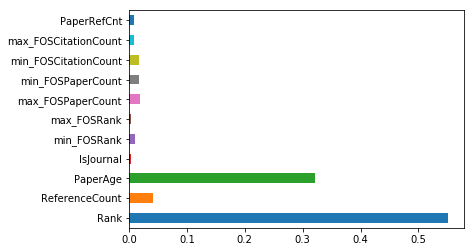

In [39]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [40]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.55081
Feature: 1, Score: 0.04081
Feature: 2, Score: 0.32178
Feature: 3, Score: 0.00277
Feature: 4, Score: 0.01098
Feature: 5, Score: 0.00297
Feature: 6, Score: 0.01915
Feature: 7, Score: 0.01755
Feature: 8, Score: 0.01705
Feature: 9, Score: 0.00812
Feature: 10, Score: 0.00800


## XGBoost Regression model

In [41]:
import xgboost as xgb

In [42]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [43]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([117212, 117213, 117214, ..., 586057, 586058, 586059]), 'TEST:', array([     0,      1,      2, ..., 117209, 117210, 117211]))
('Mean Absolute Error of XGBoost Kfold:', 3.192643171056494)
('Mean Squared Error of XGBoost Kfold:', 748.1236388786251)
('Root Mean Squared Error of XGBoost Kfold:', 27.351848911520133)
('TRAIN:', array([     0,      1,      2, ..., 586057, 586058, 586059]), 'TEST:', array([117212, 117213, 117214, ..., 234421, 234422, 234423]))
('Mean Absolute Error of XGBoost Kfold:', 1.461636112403669)
('Mean Squared Error of XGBoost Kfold:', 456.34340772515753)
('Root Mean Squared Error of XGBoost Kfold:', 21.36219576085655)
('TRAIN:', array([     0,      1,      2, ..., 586057, 586058, 586059]), 'TEST:', array([234424, 234425, 234426, ..., 351633, 351634, 351635]))
('Mean Absolute Error of XGBoost Kfold:', 0.4946313716726218)
('Mean Squared Error of XGBoost Kfold:', 35.035582198488456)
('Root Mean Squared Error of XGBoost Kfold:', 5.919086263815426)
('TRAI

In [44]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 18.047245908668394)


In [45]:
importances = regressor.feature_importances_

In [46]:
import pandas as pd

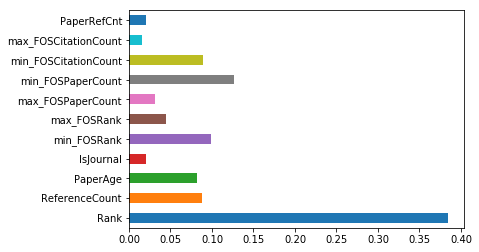

In [47]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [48]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.38416
Feature: 1, Score: 0.08856
Feature: 2, Score: 0.08142
Feature: 3, Score: 0.02008
Feature: 4, Score: 0.09850
Feature: 5, Score: 0.04410
Feature: 6, Score: 0.03148
Feature: 7, Score: 0.12703
Feature: 8, Score: 0.08879
Feature: 9, Score: 0.01547
Feature: 10, Score: 0.02040


In [26]:
y[0:5]

array([0, 1, 0, 0, 3], dtype=int32)

In [27]:
kfold = model_selection.KFold(n_splits=5, random_state=10)
model = RandomForestRegressor(n_estimators= 1000,max_depth=3)

In [28]:

results = model_selection.cross_val_score(model, X, y, cv=kfold,scoring="neg_mean_absolute_error")

In [29]:
print("Neg Mean Abosulte error: %.3f%% " % (results.mean()))

Neg Mean Abosulte error: -3.175% 


In [2]:
import numpy as np

In [3]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}